In [4]:
from data_retriever import DataRetriever
from pre_processing import PreProcessing
from scalers.min_max import MinMax
from regressors.lstm_regressor import LSTMRegressor
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from decomposers.wavelet_transform import WaveletDecomposition
from chm.chm import CascadeHierarquicalModel

In [21]:
from typing                 import List
from chm.level              import CHMLevel
from chm.stages             import CHMStage
from decomposers.decomposer import BaseDecomposer
from regressors.regressor   import BaseRegressor
from copy import copy
from pandas.core.frame import DataFrame
from copy import deepcopy
import seaborn as sns
from matplotlib import pyplot as plt
import os
from math import floor

class CascadeHierarquicalModel():
    """
    Cascade Hierarquical Model used to extract context from timeseries and predict non stationary timeseries

    parameters : BaseRegressor    (Instanciated base regressor used to extract context)
                 BaseRegressor    (Instanciated base regressor used to join context created from the stages)
                 SeriesDecomposer (decomposition used to extract frequency from time series)
                 int              (number of levels in the hierarquical model)
                 int              (number of stages in the hierarquical model)
                 bool             (use frequency extracted from time series as a feature)
    
    """
    
    def __init__(self,  ds:DataFrame                      ,
                        # x_cols:List[str]                  ,
                        y_cols:str                        ,
                        context_regressor:BaseRegressor   , 
                        stage_regressor:BaseRegressor     ,
                        decomposer:BaseDecomposer         ,
                        dec_cols:List[str]                ,
                        num_stages:int=1                  ,
                        use_frequency:bool=False          ,
                        verbose=True
                ):
        self._ds                                   = ds
        # self._x_cols                             = x_cols
        self._y_cols                               = y_cols
        self._context_regressor                    = context_regressor
        self._stage_regressor                      = stage_regressor
        self._dec                                  = decomposer()
        self._dec_cols                             = dec_cols
        self._num_stages                           = num_stages
        self._use_frequency                        = use_frequency
        self._list_stages_bottom_up:List[CHMStage] = list()
        self._list_levels_frequency:List[CHMLevel] = list()
        self._verbose                              = verbose
        self._n_inputs                             = 7
        # Decomposing series
        self._dec.decompose_series(
                                    ds         = self._ds,
                                    apply_cols = self._dec_cols
                                )
        
        # Obtaining the biggest decomposition
        self._max_wave = len(self._dec.dict_waves[y_cols])
        
    def train_context_extraction(self) -> None:
        self._set_bottom_up_block()
        self._set_top_down_block()
    
    def predict(self):
        if(self._verbose):
            print('============================================================')
            print('Predicting next value ...')

        reg = self._list_stages_bottom_up[0]._regressor
        return reg.predict_generator(reg.ds[reg.x_cols], predict_last = True)


    def _set_top_down_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Setting top-down regressors ...')
        for stage, stage_number in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
            stage_ds = pd.DataFrame()
            if self._verbose:
                print('Creating topdown regressor of Stage > ', stage_number)

            for level, level_number in zip(stage._level_list, range(len(stage._level_list))):
                stage_ds['context_level_' + str(level_number)] = level.gerenerated_context.ravel()[-stage._max_level_start_index:]
                
            for frequency_number in range(len(self._dec.dict_waves[self._y_cols])):
                stage_ds['frequency_level_' + str(frequency_number)] = self._ds[self._dec.dict_waves[self._y_cols][frequency_number]][-stage._max_level_start_index:].reset_index(drop=True)
                

            top_down_ds = pd.DataFrame()
            for level in range(len(stage._level_list)):
                top_down_ds['input_level_' + str(level)] = stage_ds['context_level_' + str(level)]
                for frequency_reversed in reversed(range(len(self._dec.dict_waves[self._y_cols]))):
                    if frequency_reversed < level :
                        top_down_ds['input_level_' + str(level)] = top_down_ds['input_level_' + str(level)] + stage_ds['frequency_level_' + str(frequency_reversed)]
            
            top_down_ds[self._y_cols] = self._ds[self._y_cols].to_list()[-stage._max_level_start_index:]
            curr_feat_cols = top_down_ds.columns.difference([self._y_cols])
    
            stage._regressor = self._context_regressor(
                                                        ds=top_down_ds, 
                                                        x_cols=curr_feat_cols, 
                                                        y_cols=self._y_cols, 
                                                        n_inputs=self._n_inputs, 
                                                        n_features=len(curr_feat_cols), 
                                                        epochs=50
                                                    )
            if self._verbose:
                print('Training topdown regressor of Stage > ', stage_number)
            stage._regressor.fit_generator()
        

    def _set_bottom_up_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Setting up bottom up block ...')

        # Ravel all subwaves names on a single list
        sub_waves = list() 
        for i in self._dec.dict_waves.keys():
            sub_waves = sub_waves + self._dec.dict_waves[i]

        # For each stage
        for stage in range(self._num_stages):
            max_len = 0
            start_index = 0
            
            # Copying temporary dict of waves
            temp_dec_dict = deepcopy(self._dec.dict_waves)

            # List of levels for this stage
            temp_level_list:List[CHMLevel] = list()

            # Set last level var
            last_level:CHMLevel = None

            # For each level in the current stage
            for level in range(self._max_wave):
                if(self._verbose):
                    print('Setting up > ', 'Level > ', level, ' of Stage > ', stage)
                

                #start_index = level * self._n_inputs
                temp_ds = self._ds.copy(deep=True)
                temp_ds = temp_ds[start_index:]
                

                # Creating dataset for this level
                for wave in temp_dec_dict.keys():

                    # Initiating sintetized column of wave
                    temp_ds[wave + '_sintetized'] = 0   

                    # For each decomposed subwave of current wave
                    for col in temp_dec_dict[wave]:
                        temp_ds[wave + '_sintetized'] = temp_ds[wave + '_sintetized'] + temp_ds[col]
                        
                # Dropping used subwave
                temp_ds.drop(sub_waves, axis=1, inplace=True)
                
                # Dropping original waves
                temp_ds.drop(self._dec_cols, axis=1, inplace=True)

                # Adding last level context if not first level
                #if last_level is not None:
                #    temp_ds['prev_level_context'] = last_level.gerenerated_context

                # List of features of current level
                curr_feat_cols = temp_ds.columns.difference(['Date'])

                # Instantiating CHM Level
                temp_level = CHMLevel(self._context_regressor(
                                                                ds=temp_ds.copy(deep=True), 
                                                                x_cols=curr_feat_cols, 
                                                                y_cols=y_cols + '_sintetized', 
                                                                n_inputs=self._n_inputs, 
                                                                n_features=len(curr_feat_cols), 
                                                                epochs=50
                                                             ),
                                                             start_index
                                        )

                if(self._verbose):
                    print('Training Regressors > ', 'Level > ', level, ' of Stage > ', stage)
                # Training Level
                temp_level.train()

                if(self._verbose):
                    print('Creating Context > ', 'Level > ', level, ' of Stage > ', stage)
                # Creating context for level
                temp_level.create_context(temp_level._regressor.ds[temp_level._regressor.x_cols], predict_last=False)

                # Appending level to list of levels of stage
                temp_level_list.append(temp_level)

                # Setting last level reference
                last_level = temp_level

                max_len = len(temp_level.gerenerated_context)

                for k in temp_dec_dict.keys():
                    if len(temp_dec_dict[k]) > 1:
                        temp_dec_dict[k].pop()

            stage_temp:CHMStage = CHMStage(temp_level_list, None)
            stage_temp._max_level_start_index = max_len
            self._list_stages_bottom_up.append(stage_temp)

    def _print_bottom_up_series(self, show_picture=False, save_picture=True):
        sns.set_style("whitegrid")

        index_col = 'Date'

        for stage, stage_num in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
            for level, level_num in zip(stage._level_list, range(len(stage._level_list))):
                for col in level._regressor.ds.columns.difference([index_col]):
                        
                    temp_ds = level._regressor.ds.copy(deep=True)

                    #Plotting Y
                    plt.plot(temp_ds[col], label=col)

                    if col == level._regressor.y_cols:
                        pred = pd.DataFrame(level.gerenerated_context)
                        pred.columns = ['Prediction']
                        begin_idx  = len(temp_ds) - len(pred)
                        finish_idx = len(temp_ds) - 1
                        pred.index = list(range(begin_idx, finish_idx + 1))
                        temp_ds = temp_ds.join(pred)
                        plt.plot(temp_ds[col], 'r', label='Prediction')

                    #Adding legends to plot
                    plt.legend()

                    #Setting to show only n of dates on X-Axis
                    n = 30
                    num_dates = np.arange(0, len(temp_ds), n)
                    plt.xticks(num_dates, [(temp_ds[index_col][i]).strftime('%Y-%m-%d') for i in num_dates], rotation='vertical')

                    if save_picture:
                        folder = '../figs/CHM/bottom_up_block/stage/' + str(stage_num) + '/level' + str(level_num) + '/' 
                        if not os.path.exists(folder):
                            os.makedirs(folder)

                        plt.savefig(folder + col + '.png')
                    
                    if show_picture:
                        plt.show()

                    plt.clf()
    
    def _print_frequency_predictor_series(self, show_picture=False, save_picture=True):
        sns.set_style("whitegrid")

        index_col = 'Date'

        for level, level_num in zip(self._list_levels_frequency, range(len(self._list_levels_frequency))):
            for col in level._regressor.ds.columns.difference([index_col]):
                    
                #Setting width of figure based on how many observations it has
                #plt.figure(figsize=(floor(len(level._regressor.ds)*0.5),10))

                temp_ds = level._regressor.ds.copy(deep=True)

                #Plotting Y
                plt.plot(temp_ds[col], label=col)

                if col == level._regressor.y_cols:
                    pred = pd.DataFrame(level.gerenerated_context)
                    pred.columns = ['Prediction']
                    begin_idx  = len(temp_ds) - len(pred)
                    finish_idx = len(temp_ds) - 1
                    pred.index = list(range(begin_idx, finish_idx + 1))
                    temp_ds = temp_ds.join(pred)
                    plt.plot(temp_ds[col], 'r', label='Prediction')

                #Adding legends to plot
                plt.legend()

                #Setting to show only n of dates on X-Axis
                n = 30
                num_dates = np.arange(0, len(temp_ds), n)
                plt.xticks(num_dates, [(temp_ds[index_col][i]).strftime('%Y-%m-%d') for i in num_dates], rotation='vertical')

                if save_picture:
                    folder = '../figs/CHM/frequency_predictor/level' + str(level_num) + '/' 
                    if not os.path.exists(folder):
                        os.makedirs(folder)

                    plt.savefig(folder + col + '.png')
                
                if show_picture:
                    plt.show()
                plt.clf()

    def __sintetize_series(self):
        pass

    def __recompose_series(self):
        pass

    

In [22]:
#Retrieving data from yahoo API
a = DataRetriever()
a.get_yahoo_stock_data()

#Defining which stocks will be predicted
#x_cols_ = [x for x in b.columns.difference(['Date']) if x[-5:] == 'Close']
predict_cols = 'ITUB3.SA_Close'

#Obtaining yahoo dataset
dataset = a.get_stock_ds()

#Preprocessing yahoo data
pp = PreProcessing(dataset, MinMax)
train, test = pp.pre_process()

#Setting up column to be predicted
y_cols = predict_cols
#Setting up column to be used as features
x_cols = train.columns.difference(['Date'])


[*********************100%***********************]  7 of 7 completed


In [23]:
chm = CascadeHierarquicalModel(train.copy(deep= True),
                                y_cols            = predict_cols,
                                context_regressor = LSTMRegressor,
                                stage_regressor   = LSTMRegressor,
                                decomposer        = WaveletDecomposition,
                                dec_cols          = x_cols
                                
                            )

c:\Users\Usuario\Desktop\Mestrado\stock-market-chm\src\decomposers\wavelet_transform.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[new_col] = rec[:len(rec)-1]


In [24]:
chm._list_stages_bottom_up[0]._level_list[0]._regressor.ds

IndexError: list index out of range

In [25]:
chm.train_context_extraction()


Setting up bottom up block ...
Setting up >  Level >  0  of Stage >  0
Training Regressors >  Level >  0  of Stage >  0
Creating Context >  Level >  0  of Stage >  0
Setting up >  Level >  1  of Stage >  0
Training Regressors >  Level >  1  of Stage >  0
Creating Context >  Level >  1  of Stage >  0
Setting up >  Level >  2  of Stage >  0
Training Regressors >  Level >  2  of Stage >  0
Creating Context >  Level >  2  of Stage >  0
Setting up >  Level >  3  of Stage >  0
Training Regressors >  Level >  3  of Stage >  0
Creating Context >  Level >  3  of Stage >  0
Setting up >  Level >  4  of Stage >  0
Training Regressors >  Level >  4  of Stage >  0
Creating Context >  Level >  4  of Stage >  0
Setting up >  Level >  5  of Stage >  0
Training Regressors >  Level >  5  of Stage >  0
Creating Context >  Level >  5  of Stage >  0
Setting up >  Level >  6  of Stage >  0
Training Regressors >  Level >  6  of Stage >  0
Creating Context >  Level >  6  of Stage >  0
Setting up >  Level >  7

In [26]:
chm._list_stages_bottom_up[0]._level_list[2].gerenerated_context


array([[0.14474715],
       [0.1425495 ],
       [0.14063197],
       ...,
       [0.8592201 ],
       [0.8584348 ],
       [0.8559061 ]], dtype=float32)

In [28]:
chm._list_stages_bottom_up[0]._regressor.ds

,input_level_0,input_level_1,input_level_2,input_level_3,input_level_4,input_level_5,input_level_6,input_level_7,input_level_8,ITUB3.SA_Close
0,0.126518,0.275075,0.285276,0.285493,0.293729,0.283493,0.280264,0.267957,0.313199,0.153703
1,0.124778,0.272532,0.282718,0.283642,0.291394,0.281085,0.277401,0.267350,0.311928,0.142680
2,0.121435,0.270318,0.280472,0.281606,0.289257,0.278959,0.274555,0.268122,0.310045,0.145742
3,0.119782,0.269160,0.278694,0.279330,0.287137,0.276850,0.271211,0.265865,0.307218,0.145742
4,0.117570,0.268362,0.276715,0.276734,0.285007,0.274772,0.267326,0.260156,0.302616,0.143701
...,...,...,...,...,...,...,...,...,...,...
1919,0.834036,1.746962,1.710501,1.730041,1.701162,1.745819,1.745842,1.733444,1.713175,0.857687
1920,0.847520,1.742595,1.714675,1.715961,1.690553,1.738377,1.738928,1.725502,1.712318,0.856457
1921,0.850937,1.740394,1.712609,1.705066,1.681508,1.731944,1.732903,1.720944,1.709888,0.858096
1922,0.843558,1.740775,1.711303,1.697243,1.673610,1.727487,1.727966,1.711479,1.704133,0.846003


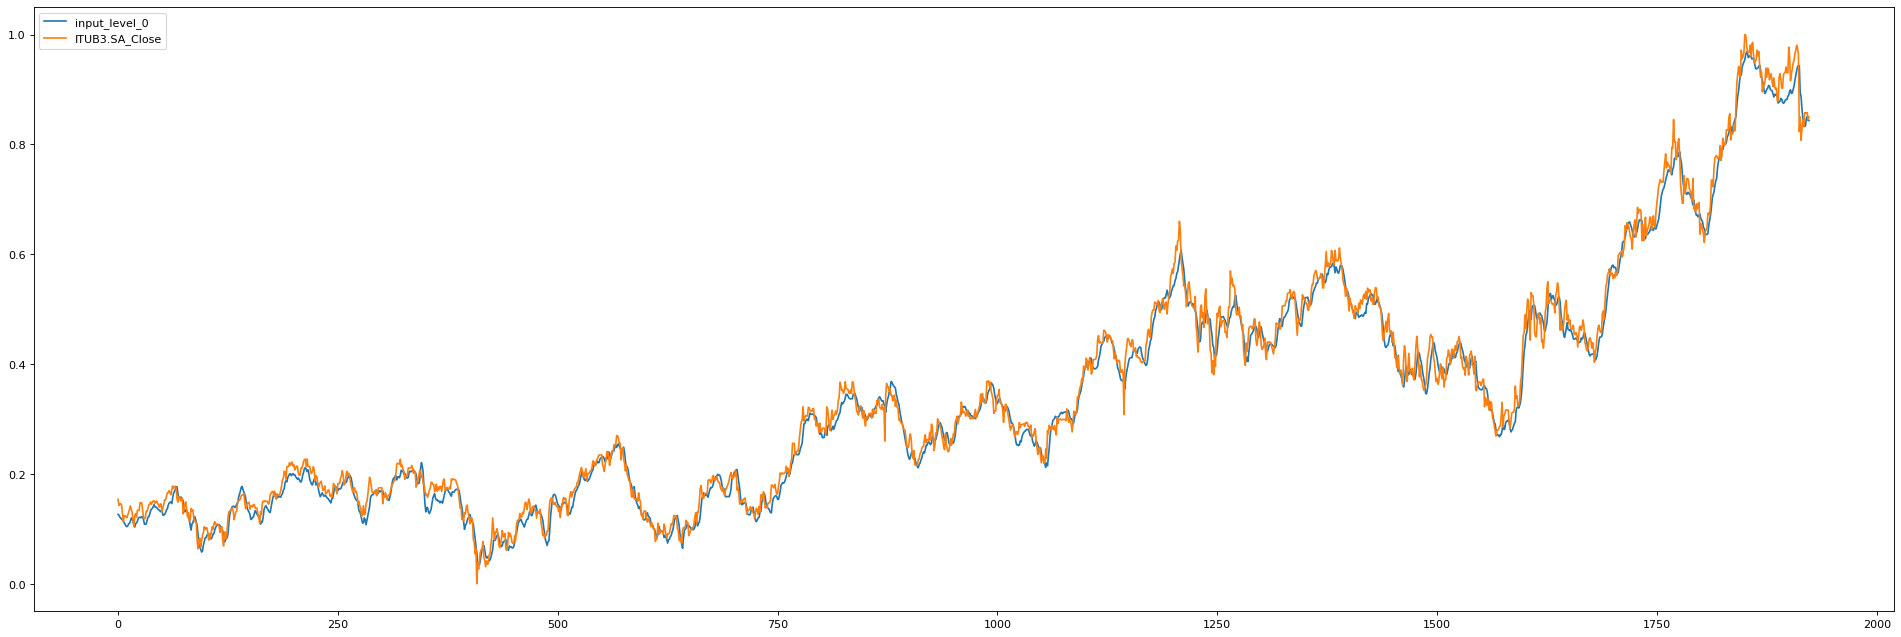

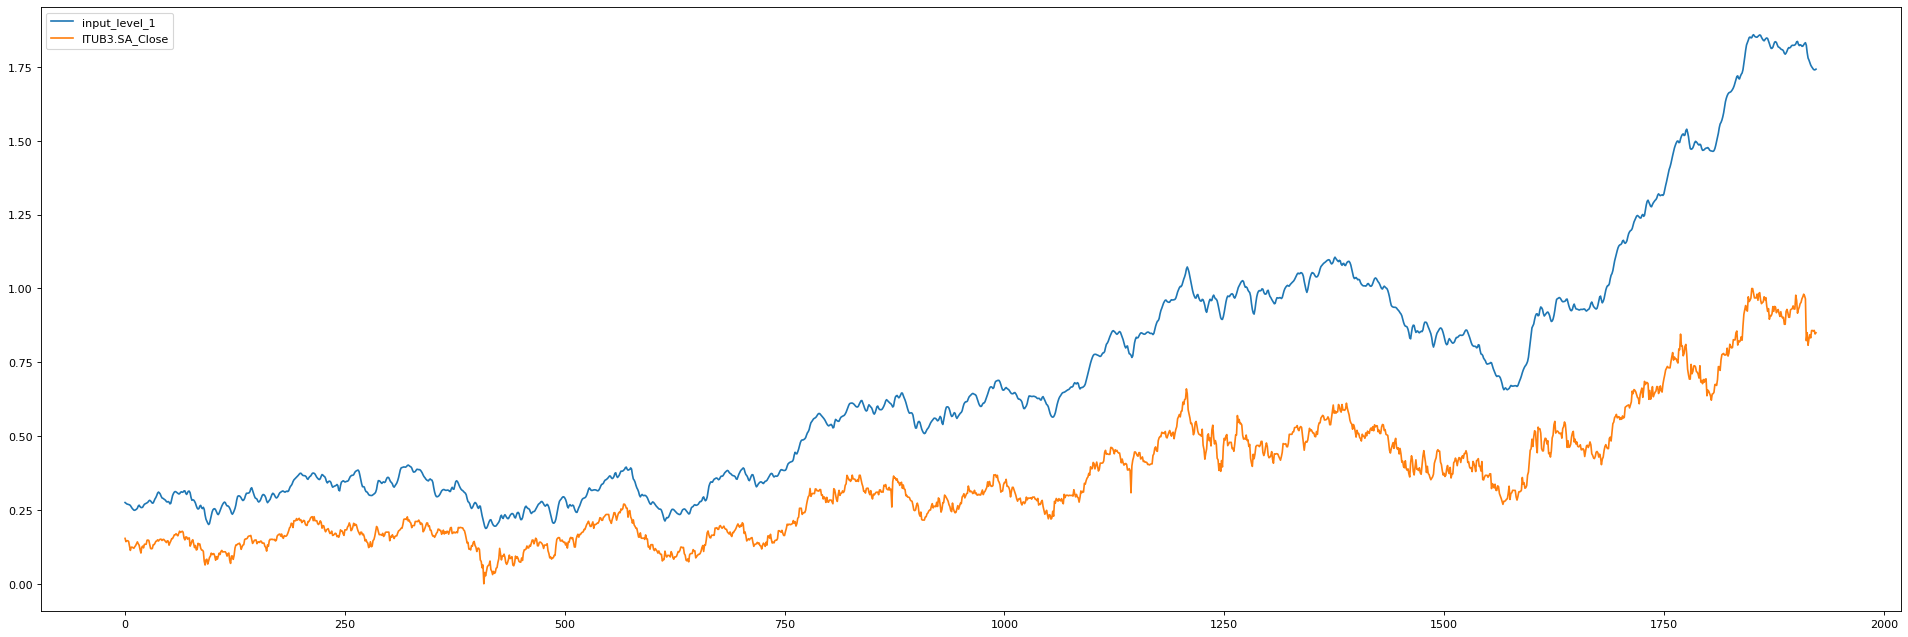

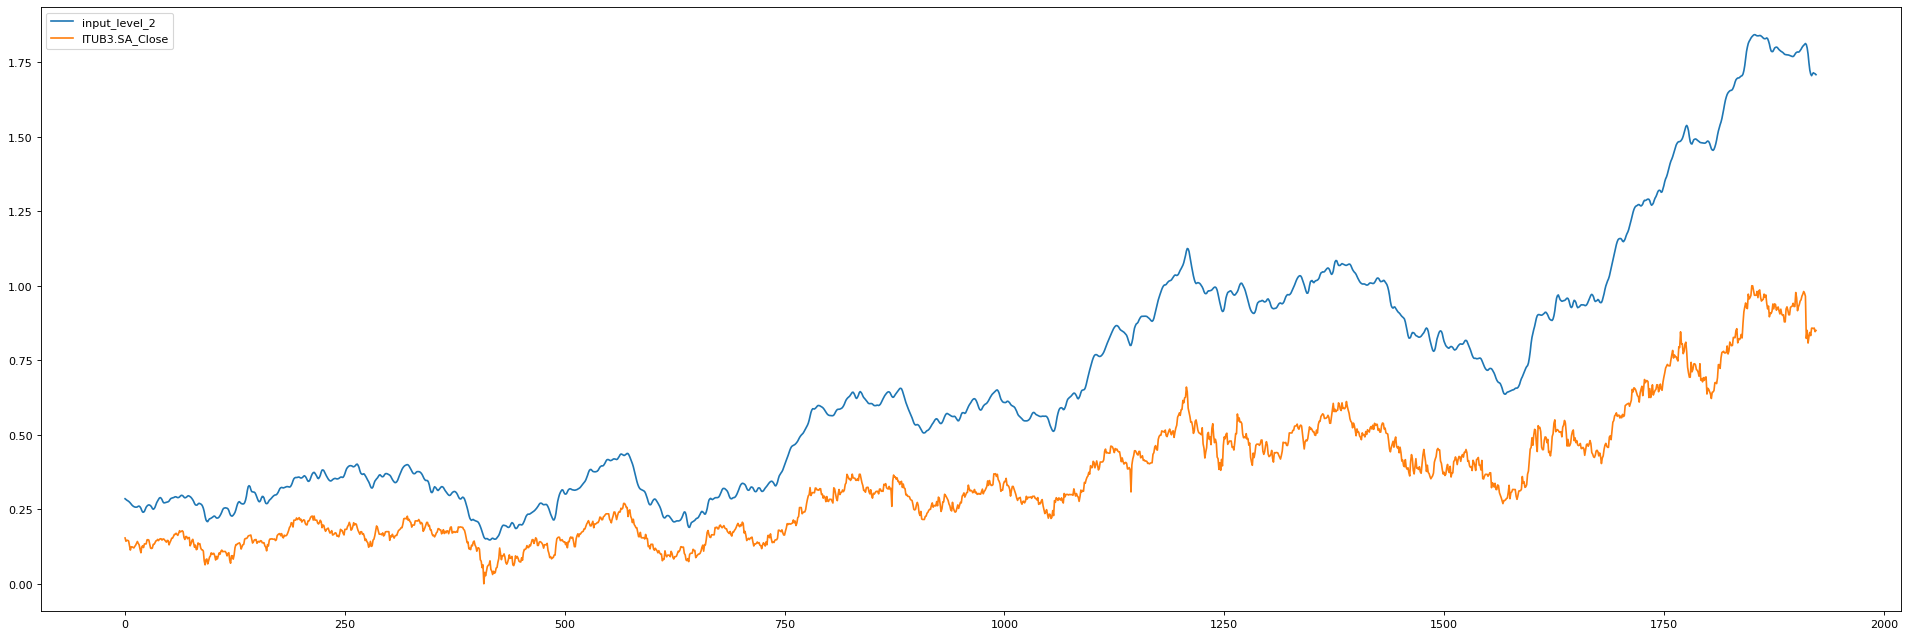

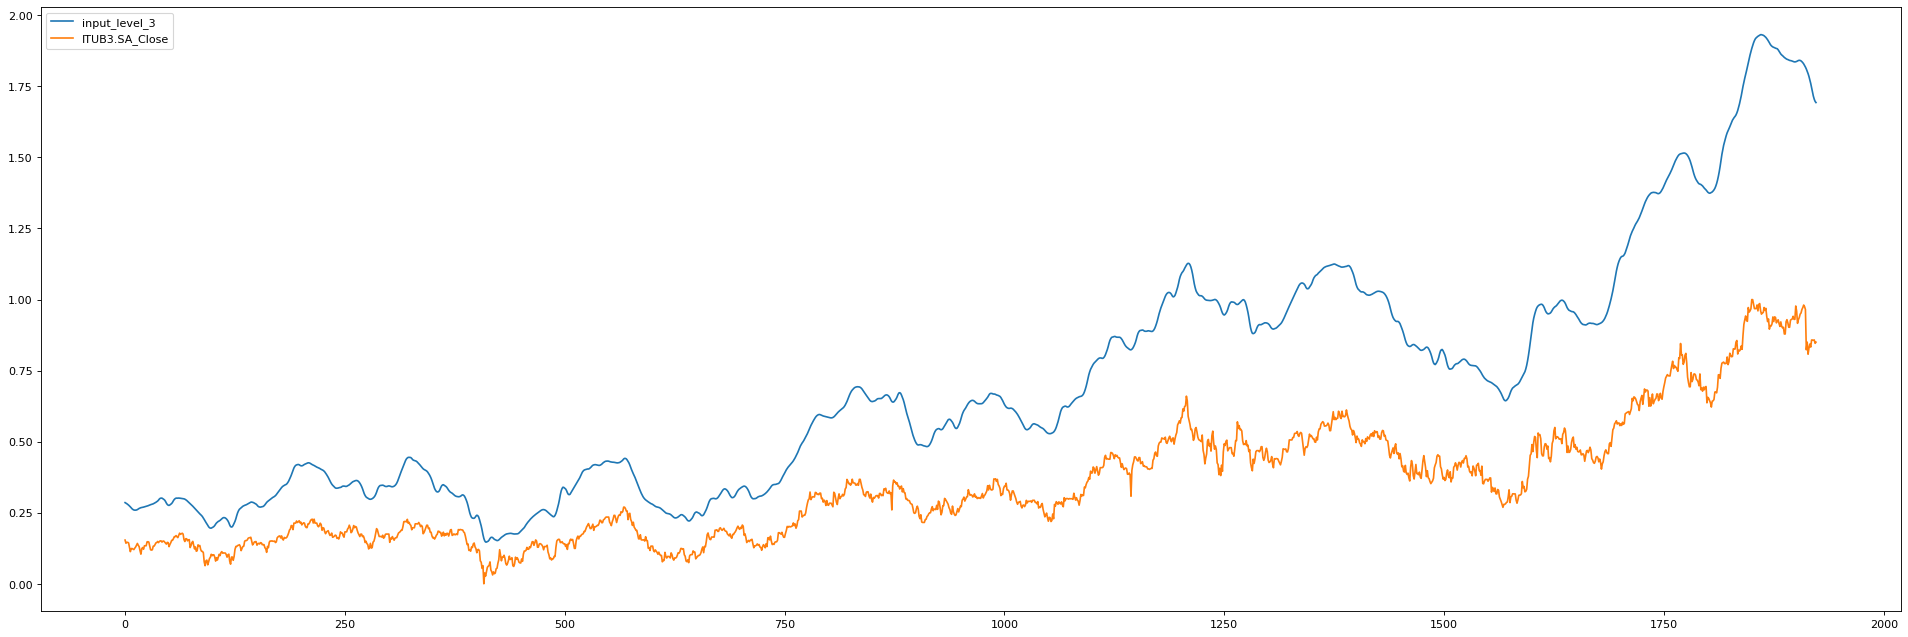

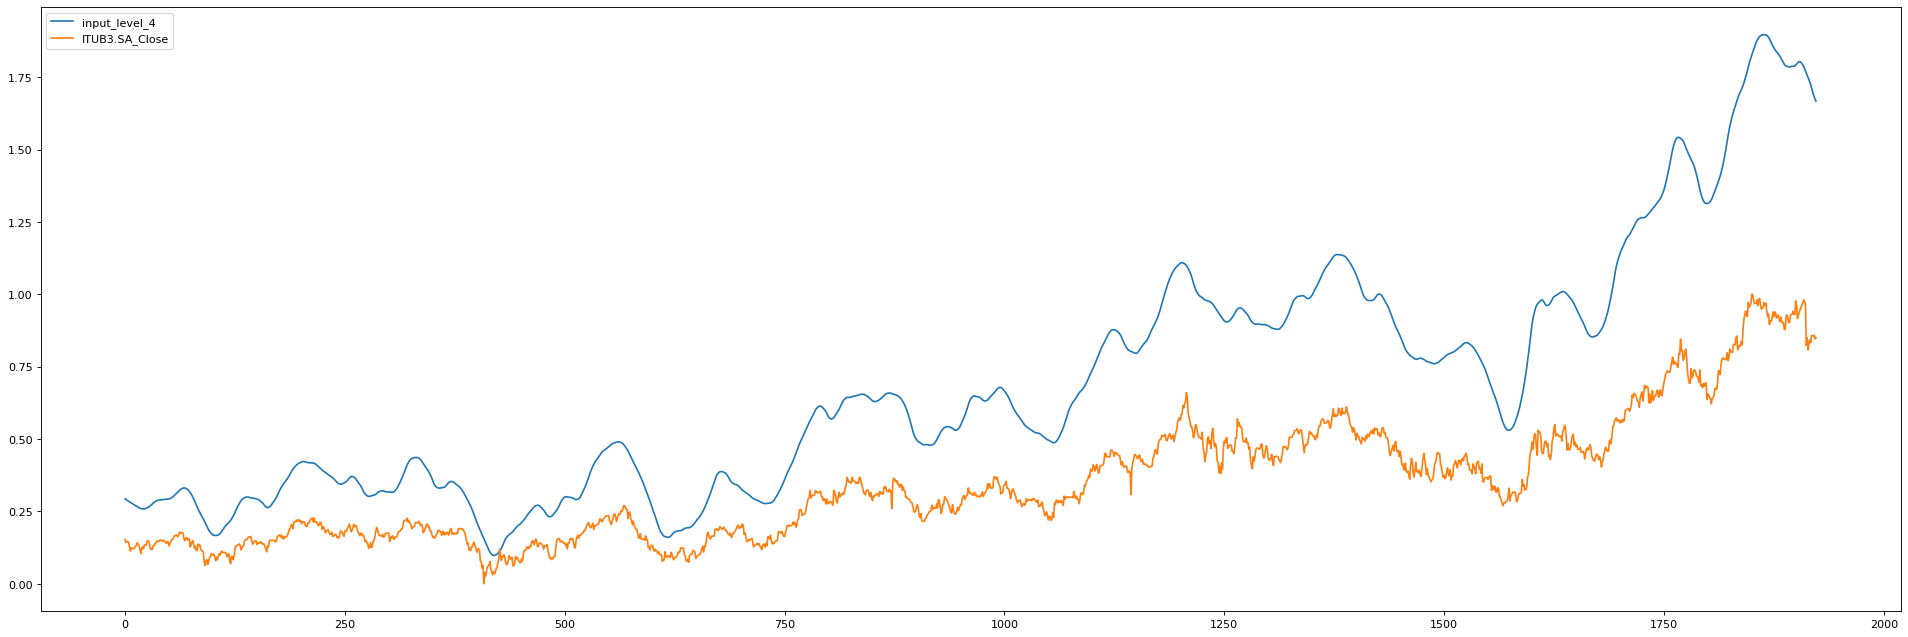

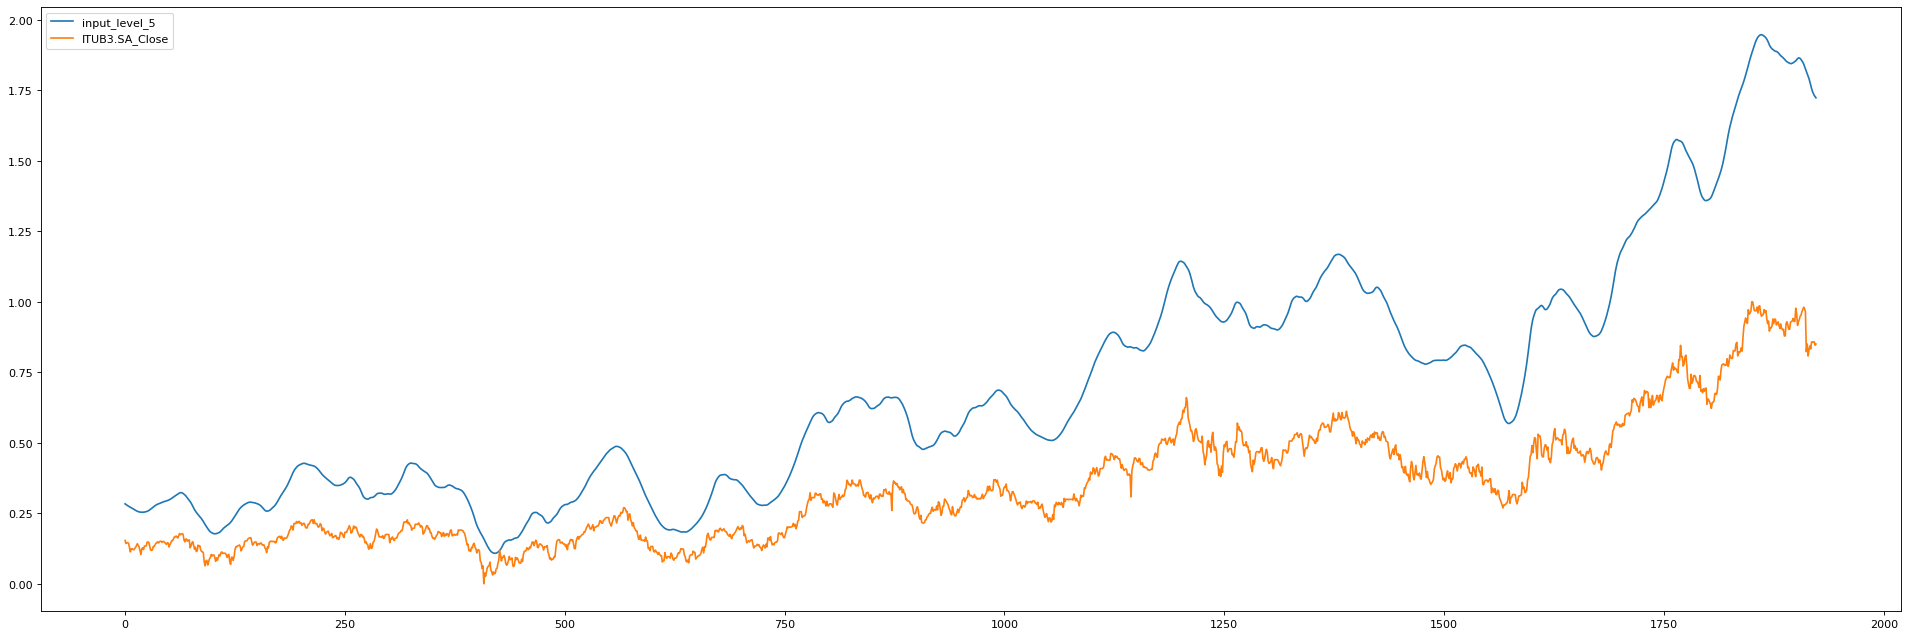

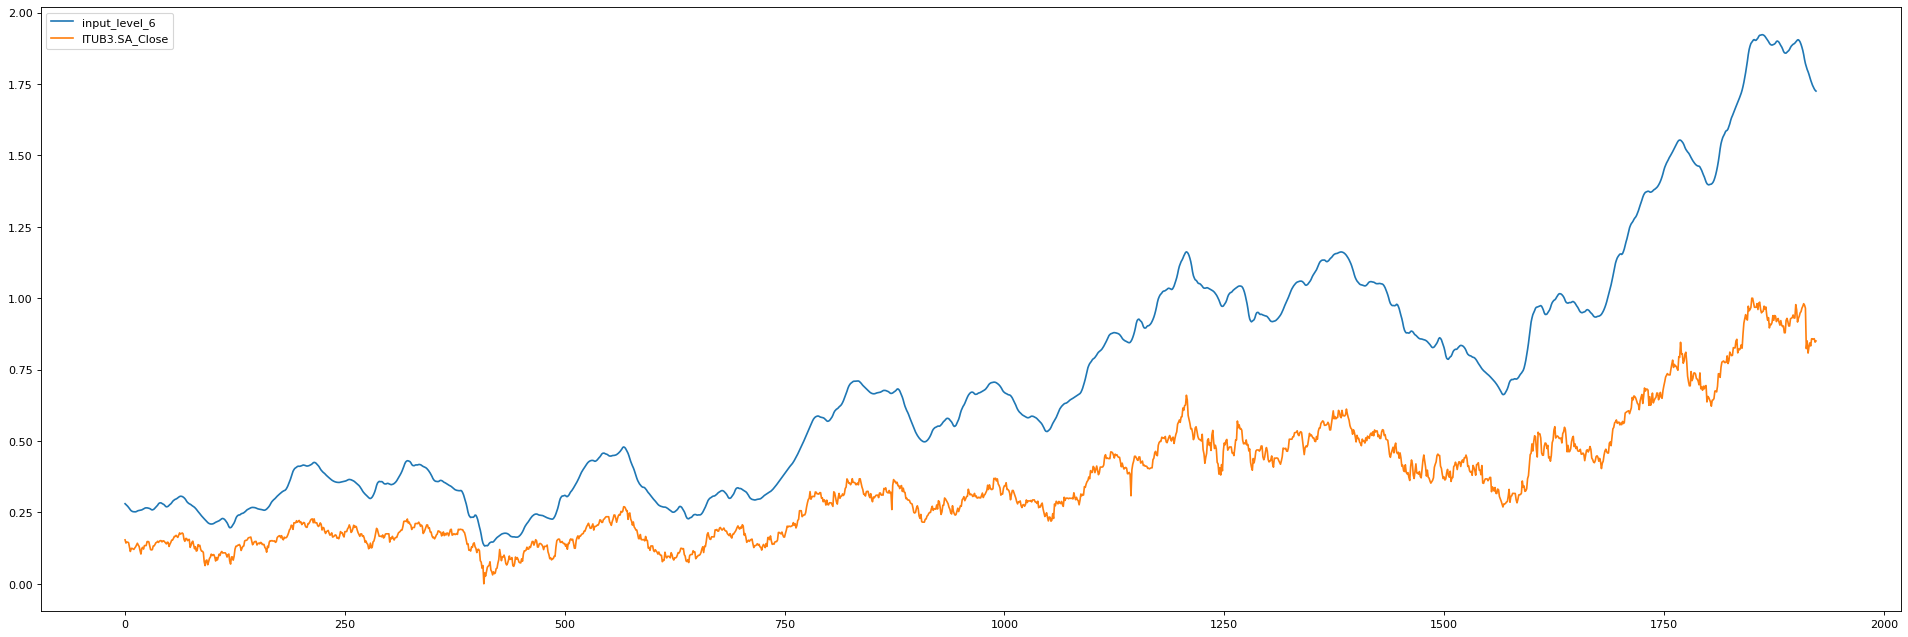

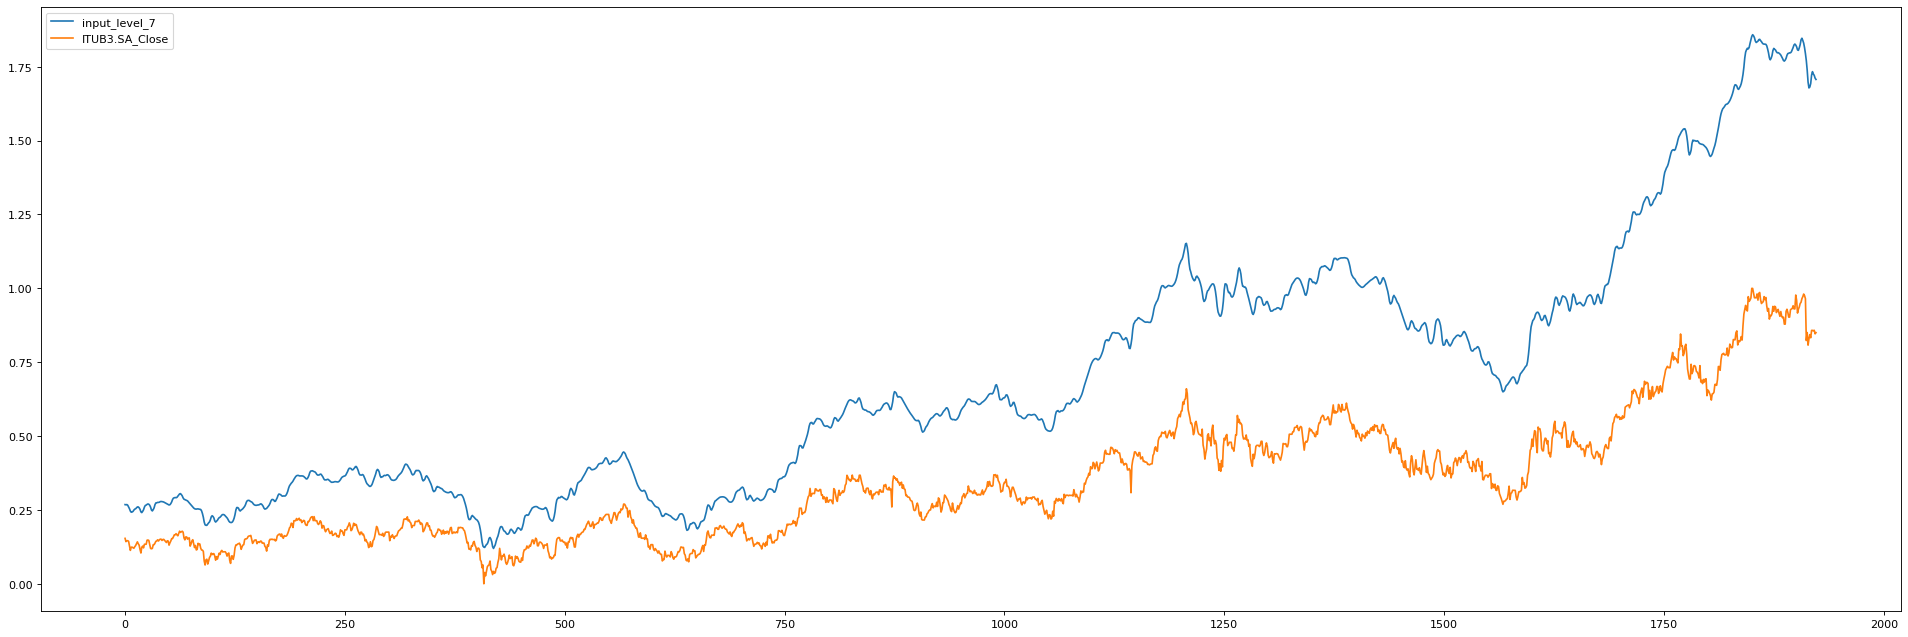

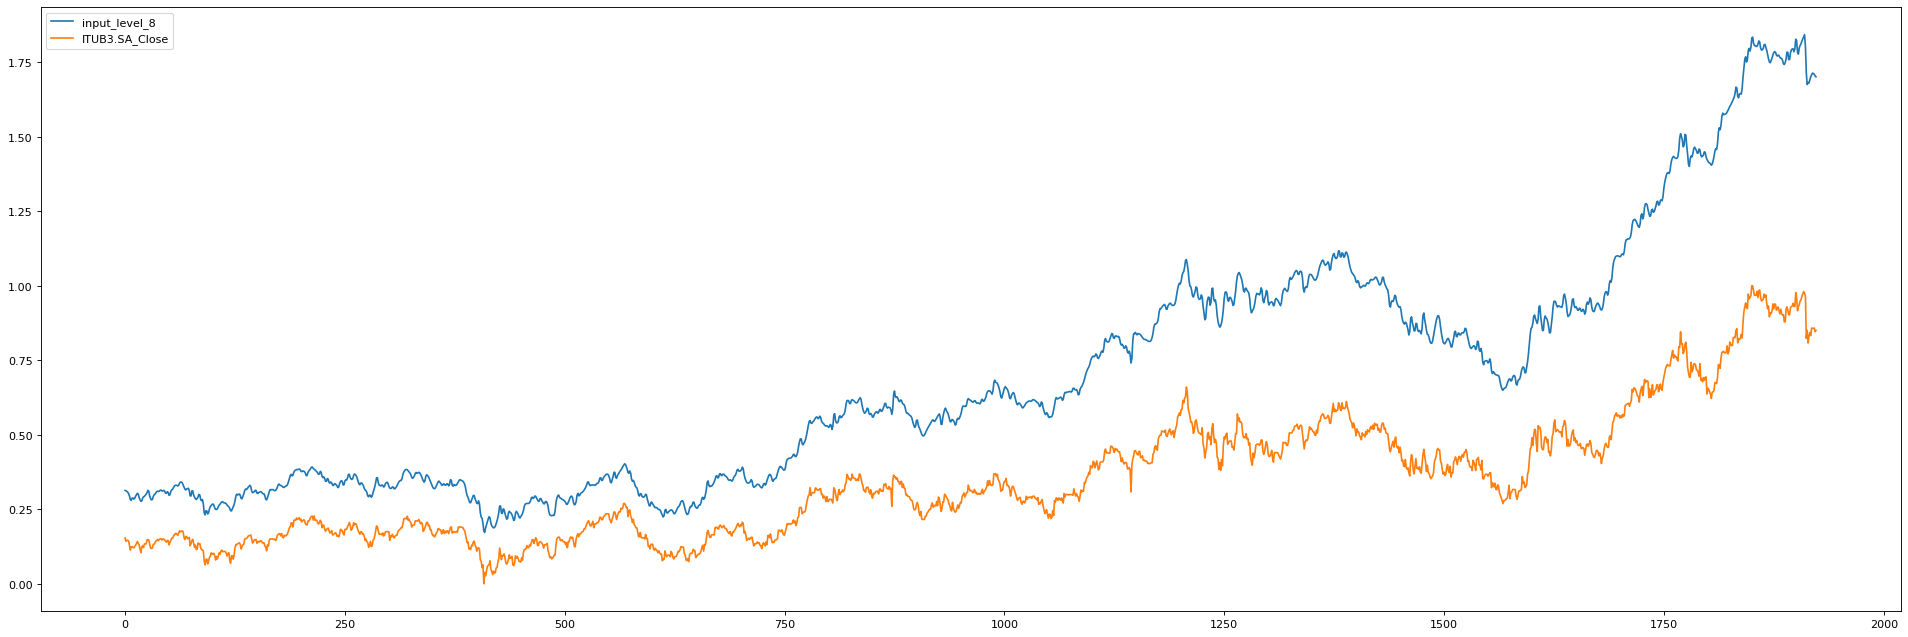

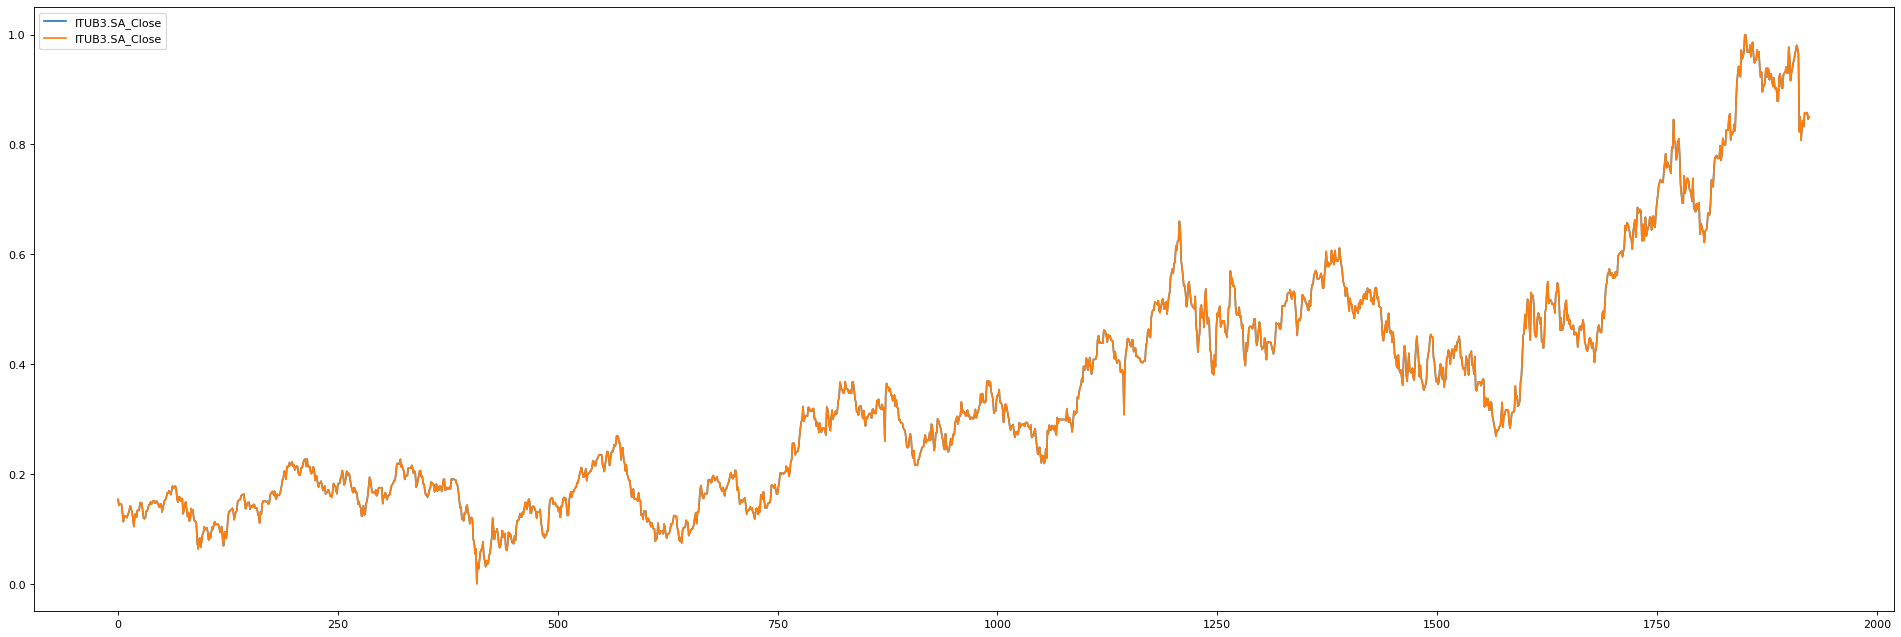

Predicting next value ...


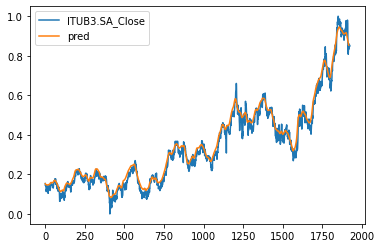

In [27]:

for i in chm._list_stages_bottom_up[0]._regressor.ds.columns:
    plt.figure(figsize=(30, 10), dpi=80)
    plt.plot(chm._list_stages_bottom_up[0]._regressor.ds[i], label=i)
    plt.plot(chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close'], label='ITUB3.SA_Close')
    
    plt.legend()
    plt.show()
    
plt.plot(chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close'], label='ITUB3.SA_Close')
plt.plot(chm.predict(), label='pred')
    
plt.legend()
plt.show()

In [33]:
stage_ds = pd.DataFrame()

for level, level_number in zip(chm._list_stages_bottom_up[0]._level_list, range(len(chm._list_stages_bottom_up[0]._level_list))):
    stage_ds['context_level_' + str(level_number)] = level.gerenerated_context.ravel()[-chm._list_stages_bottom_up[0]._max_level_start_index:]

In [34]:
for frequency_number in range(len(chm._dec.dict_waves[chm._y_cols])):
    print(chm._dec.dict_waves[chm._y_cols][frequency_number])
    
    stage_ds['frequency_level_' + str(frequency_number)] = chm._ds[chm._dec.dict_waves[chm._y_cols][frequency_number]][-chm._list_stages_bottom_up[0]._max_level_start_index:].reset_index(drop=True)

ITUB3.SA_Close_wave_0
ITUB3.SA_Close_wave_1
ITUB3.SA_Close_wave_2
ITUB3.SA_Close_wave_3
ITUB3.SA_Close_wave_4
ITUB3.SA_Close_wave_5
ITUB3.SA_Close_wave_6
ITUB3.SA_Close_wave_7
ITUB3.SA_Close_wave_8


In [35]:
stage_ds

,context_level_0,context_level_1,context_level_2,context_level_3,context_level_4,context_level_5,context_level_6,context_level_7,context_level_8,frequency_level_0,frequency_level_1,frequency_level_2,frequency_level_3,frequency_level_4,frequency_level_5,frequency_level_6,frequency_level_7,frequency_level_8
0,0.158574,0.196255,0.183192,0.156740,0.167960,0.085143,0.127002,0.132764,0.140208,0.143830,-0.009348,-0.001283,0.018640,0.005634,0.003944,0.001727,0.001306,0.001180
1,0.160439,0.200709,0.184874,0.159676,0.170488,0.085440,0.127898,0.132972,0.140256,0.143858,-0.009289,-0.001604,0.019862,0.006121,0.004270,0.000959,0.003051,-0.001597
2,0.160111,0.200311,0.184068,0.161176,0.172812,0.085849,0.128797,0.133185,0.140306,0.143886,-0.009230,-0.001937,0.021092,0.006524,0.003803,-0.000643,0.003797,0.002266
3,0.159769,0.195272,0.181234,0.160116,0.174944,0.086393,0.129695,0.133401,0.140357,0.143920,-0.009161,-0.002271,0.022385,0.007033,0.003832,-0.000760,0.001805,-0.001357
4,0.159128,0.190937,0.178332,0.159990,0.176779,0.086945,0.130603,0.133628,0.140410,0.143960,-0.009082,-0.002603,0.023743,0.007662,0.004402,0.001054,-0.004225,-0.002586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,0.869801,0.818017,0.893772,0.860648,0.936705,0.856051,0.868932,0.834766,0.890663,0.871120,-0.016337,0.005629,0.004287,-0.013902,-0.004731,0.022408,-0.010239,-0.000548
1864,0.868331,0.820213,0.898412,0.854563,0.929718,0.854368,0.865289,0.833446,0.890112,0.870588,-0.016544,0.003049,0.005373,-0.017395,-0.002250,0.018497,-0.003563,-0.001297
1865,0.867212,0.823482,0.900143,0.849940,0.923762,0.852466,0.861952,0.832217,0.889614,0.870122,-0.016733,0.000666,0.006272,-0.019934,-0.000136,0.017208,-0.001806,0.002437
1866,0.866797,0.824764,0.904602,0.846424,0.918601,0.850461,0.858861,0.831077,0.889169,0.869764,-0.016895,-0.001363,0.006858,-0.020618,0.000832,0.010064,0.001552,-0.004190


In [30]:
chm._ds[chm._dec.dict_waves[chm._y_cols][0]][-chm._list_stages_bottom_up[0]._max_level_start_index:].reset_index(drop=True)

0       0.143830
1       0.143858
2       0.143886
3       0.143920
4       0.143960
          ...   
1863    0.871120
1864    0.870588
1865    0.870122
1866    0.869764
1867    0.869418
Name: ITUB3.SA_Close_wave_0, Length: 1868, dtype: float64

In [27]:
stage_ds

,context_level_0,context_level_1,context_level_2,context_level_3,context_level_4,context_level_5,context_level_6,context_level_7,context_level_8,frequency_level_0,frequency_level_1,frequency_level_2,frequency_level_3,frequency_level_4,frequency_level_5,frequency_level_6,frequency_level_7,frequency_level_8
0,0.158574,0.196255,0.183192,0.156740,0.167960,0.085143,0.127002,0.132764,0.140208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.160439,0.200709,0.184874,0.159676,0.170488,0.085440,0.127898,0.132972,0.140256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.160111,0.200311,0.184068,0.161176,0.172812,0.085849,0.128797,0.133185,0.140306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.159769,0.195272,0.181234,0.160116,0.174944,0.086393,0.129695,0.133401,0.140357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.159128,0.190937,0.178332,0.159990,0.176779,0.086945,0.130603,0.133628,0.140410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,0.869801,0.818017,0.893772,0.860648,0.936705,0.856051,0.868932,0.834766,0.890663,0.866184,-0.001767,0.072378,0.008314,0.032250,-0.009136,-0.001265,0.000992,0.013027
1864,0.868331,0.820213,0.898412,0.854563,0.929718,0.854368,0.865289,0.833446,0.890112,0.866703,-0.001877,0.075935,0.007677,0.030527,-0.010613,0.000512,0.004517,-0.013286
1865,0.867212,0.823482,0.900143,0.849940,0.923762,0.852466,0.861952,0.832217,0.889614,0.867271,-0.002008,0.078858,0.007196,0.028184,-0.008667,0.002941,0.010595,-0.001345
1866,0.866797,0.824764,0.904602,0.846424,0.918601,0.850461,0.858861,0.831077,0.889169,0.867843,-0.002145,0.081555,0.006631,0.025511,-0.008510,0.003510,0.005893,0.005600


In [21]:
stage_ds['ITUB3.SA_Close_wave_0']

,context_level_0,context_level_1,context_level_2,context_level_3,context_level_4,context_level_5,context_level_6,context_level_7,context_level_8,frequency_level_0,frequency_level_1,frequency_level_2,frequency_level_3,frequency_level_4,frequency_level_5,frequency_level_6,frequency_level_7,frequency_level_8
0,0.158574,0.196255,0.183192,0.156740,0.167960,0.085143,0.127002,0.132764,0.140208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.160439,0.200709,0.184874,0.159676,0.170488,0.085440,0.127898,0.132972,0.140256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.160111,0.200311,0.184068,0.161176,0.172812,0.085849,0.128797,0.133185,0.140306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.159769,0.195272,0.181234,0.160116,0.174944,0.086393,0.129695,0.133401,0.140357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.159128,0.190937,0.178332,0.159990,0.176779,0.086945,0.130603,0.133628,0.140410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863,0.869801,0.818017,0.893772,0.860648,0.936705,0.856051,0.868932,0.834766,0.890663,0.866184,-0.001767,0.072378,0.008314,0.032250,-0.009136,-0.001265,0.000992,0.013027
1864,0.868331,0.820213,0.898412,0.854563,0.929718,0.854368,0.865289,0.833446,0.890112,0.866703,-0.001877,0.075935,0.007677,0.030527,-0.010613,0.000512,0.004517,-0.013286
1865,0.867212,0.823482,0.900143,0.849940,0.923762,0.852466,0.861952,0.832217,0.889614,0.867271,-0.002008,0.078858,0.007196,0.028184,-0.008667,0.002941,0.010595,-0.001345
1866,0.866797,0.824764,0.904602,0.846424,0.918601,0.850461,0.858861,0.831077,0.889169,0.867843,-0.002145,0.081555,0.006631,0.025511,-0.008510,0.003510,0.005893,0.005600


In [24]:
chm._ds['ITUB3.SA_Close_wave_0']

0       0.147959
1       0.147780
2       0.147600
3       0.147417
4       0.147234
          ...   
1926    0.871120
1927    0.870588
1928    0.870122
1929    0.869764
1930    0.869418
Name: ITUB3.SA_Close_wave_0, Length: 1931, dtype: float64

In [25]:
chm._ds

,Date,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,B3SA3.SA_Open,...,MSFT_STOCHd_14_3_3_wave_8,MSFT_STOCHk_14_3_3_wave_0,MSFT_STOCHk_14_3_3_wave_1,MSFT_STOCHk_14_3_3_wave_2,MSFT_STOCHk_14_3_3_wave_3,MSFT_STOCHk_14_3_3_wave_4,MSFT_STOCHk_14_3_3_wave_5,MSFT_STOCHk_14_3_3_wave_6,MSFT_STOCHk_14_3_3_wave_7,MSFT_STOCHk_14_3_3_wave_8
0,2010-01-04,0.033912,0.028221,0.030724,0.028159,0.116881,0.118220,0.122185,0.120405,0.735941,...,6.899820e-19,0.188819,0.006776,-0.054919,-0.112475,0.044154,0.003304,0.000104,-1.331802e-18,2.299940e-18
1,2010-01-05,0.030758,0.026962,0.029229,0.029038,0.120555,0.118220,0.122984,0.120561,0.788020,...,-6.899820e-19,0.190014,0.008319,-0.054813,-0.119858,0.047971,0.003961,0.000168,1.683521e-18,-2.299940e-18
2,2010-01-06,0.032067,0.026126,0.029049,0.026322,0.121034,0.117907,0.121067,0.117601,0.784956,...,6.899820e-19,0.191220,0.009854,-0.054616,-0.127403,0.051753,0.004716,0.000239,1.331802e-18,2.299940e-18
3,2010-01-07,0.029170,0.023440,0.025846,0.023816,0.117041,0.111969,0.115797,0.112615,0.813293,...,-6.899820e-19,0.192438,0.011376,-0.054319,-0.135104,0.055478,0.005576,0.000316,-1.683521e-18,-2.299940e-18
4,2010-01-08,0.027548,0.024956,0.026105,0.027736,0.111450,0.114782,0.116596,0.115887,0.850820,...,6.899820e-19,0.193659,0.012935,-0.054024,-0.143080,0.059390,0.006473,0.000408,-1.331802e-18,2.299940e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,2017-05-29,0.994408,0.989044,0.992785,0.987808,0.985797,0.968784,0.985994,0.965841,0.442572,...,-3.020901e-02,0.748764,-0.007966,-0.003639,0.001287,0.013350,0.081176,0.060765,-2.912349e-02,-1.649252e-02
1927,2017-05-30,0.996097,0.991886,0.999831,0.988832,0.985603,0.972401,0.990857,0.974381,0.438506,...,3.826464e-03,0.748912,-0.008231,0.000592,0.008745,0.016684,0.092455,0.045792,-5.727877e-02,4.513800e-04
1928,2017-05-31,1.000000,0.990682,0.984818,0.986516,1.000000,0.978682,0.991635,0.963564,0.438167,...,6.856874e-03,0.749061,-0.008475,0.004493,0.014969,0.019010,0.091315,0.025507,-5.336475e-02,5.607434e-03
1929,2017-06-01,0.998423,0.989423,0.995168,0.987997,0.994358,0.976208,0.984632,0.968498,0.423258,...,-3.061393e-03,0.749215,-0.008690,0.007804,0.019163,0.019586,0.066769,-0.015509,1.217090e-02,-2.386900e-03


In [29]:
reg = chm._list_stages_bottom_up[0]._regressor


In [17]:
len(chm._list_stages_bottom_up[0]._level_list[8].gerenerated_context)

1868

In [46]:
for i in chm._list_stages_bottom_up[0]._level_list:
    print(len(i.gerenerated_context))

1924
1917
1910
1903
1896
1889
1882
1875
1868


In [47]:
timeseries_dataset_from_array(reg.ds[reg.x_cols][63:], None, 7)

<BatchDataset shapes: (None, None, 9), types: tf.float64>

In [53]:
reg.predict(np.concatenate([x for x in a], axis=0))

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [55]:
chm._list_stages_bottom_up[0]._regressor.ds

,input_level_0,input_level_1,input_level_2,input_level_3,input_level_4,input_level_5,input_level_6,input_level_7,input_level_8,ITUB3.SA_Close
0,0.159647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165632
1,0.161812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165632
2,0.164779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.169558
3,0.168018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165425
4,0.167711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162325
5,0.165932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.169765
6,0.167760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.178030
7,0.174221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.173898
8,0.174377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175964
9,0.174956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177824
